In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import matplotlib.pyplot as plt

C:\Users\nagar\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=pd.read_csv('highUtilizationPredictionV2wco.csv')
race_dummies=pd.get_dummies(df['race'])
newdf=pd.concat([df,race_dummies],axis=1)
del newdf['race']
del newdf['patient_id']
Y=newdf['HighUtilizationY2']
del newdf['HighUtilizationY2']
del newdf['claimCount']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(newdf, Y, test_size=0.2)

In [4]:
# Random Forest Classifier

space = [Integer(10, 60, name='n_estimators'),Integer(2, 50, name='max_features'), Categorical(['True','False'], name='bootstrap'),Integer(2, 10, name='min_samples_split'),Integer(2, 20, name='max_depth')]
@use_named_args(space)
def objective(**params):
    rf = RandomForestClassifier(**params)
    print(locals()['params'].values())
    return -np.mean(cross_val_score(rf, X_train, y_train, cv=10, n_jobs=1, scoring='roc_auc'))
reg_gp = gp_minimize(objective, space, n_calls=20, verbose=True)
round(min(reg_gp.func_vals),4)

Iteration No: 1 started. Evaluating function at random point.
dict_values([33, 5, 'False', 5, 17])
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 27.2302
Function value obtained: -0.8170
Current minimum: -0.8170
Iteration No: 2 started. Evaluating function at random point.
dict_values([51, 44, 'False', 10, 4])
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 61.2592
Function value obtained: -0.8071
Current minimum: -0.8170
Iteration No: 3 started. Evaluating function at random point.
dict_values([40, 12, 'False', 8, 16])
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 63.5051
Function value obtained: -0.8167
Current minimum: -0.8170
Iteration No: 4 started. Evaluating function at random point.
dict_values([15, 16, 'True', 7, 10])
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 19.5507
Function value obtained: -0.8183
Current minimum: -0.8183
Iteration No: 5 started. Evaluating function at random point.
dict

-0.8214

In [5]:
# Random Forest default
rf_d=RandomForestClassifier()
rf_d.fit(X_train, y_train)
rf_probs_ = rf_d.predict_proba(X_test)[:, 1]
print("AUC for Random forest -Default model:",roc_auc_score(y_test, rf_probs_))
#Random Forest with optimised hyperparameters
rf=RandomForestClassifier(n_estimators=60,max_features=2,bootstrap=False,min_samples_split=10,max_depth=20)
rf.fit(X_train, y_train)
rf_probs= rf.predict_proba(X_test)[:, 1]
print("AUC for Random forest -optimised hyper parameters model:",roc_auc_score(y_test, rf_probs))

AUC for Random forest -Default model: 0.7494067239477075
AUC for Random forest -optimised hyper parameters model: 0.8303321959404272


In [6]:
# Logistic Regression
space = [Real(0, 10, name='C'), Categorical(['newton-cg', 'lbfgs', 'liblinear'], name='solver'),Categorical([None,'balanced'],name='class_weight')]
@use_named_args(space)
def objective(**params):
    lr = LogisticRegression(**params)
    print(locals()['params'].values())
    return -np.mean(cross_val_score(lr, X_train, y_train, cv=10, n_jobs=1, scoring='roc_auc'))
reg_gp = gp_minimize(objective, space, n_calls=10, verbose=True)
round(min(reg_gp.func_vals),4)

Iteration No: 1 started. Evaluating function at random point.
dict_values([4.166643867634362, 'newton-cg', None])
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 218.2623
Function value obtained: -0.8194
Current minimum: -0.8194
Iteration No: 2 started. Evaluating function at random point.
dict_values([5.679053218771565, 'liblinear', 'balanced'])
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 62.8170
Function value obtained: -0.8211
Current minimum: -0.8211
Iteration No: 3 started. Evaluating function at random point.
dict_values([5.017759378410835, 'lbfgs', 'balanced'])
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 28.8085
Function value obtained: -0.8189
Current minimum: -0.8211
Iteration No: 4 started. Evaluating function at random point.
dict_values([2.366210231421986, 'newton-cg', 'balanced'])
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 217.1520
Function value obtained: -0.8211
Current minimum: 

-0.8211

In [11]:
#Logistic Regression default
logmodel_d = LogisticRegression()
logmodel_d.fit(X_train, y_train)
lr_probs_ = logmodel_d.predict_proba(X_test)[:, 1]
print("AUC for Logistic Regression -Default model:",roc_auc_score(y_test, lr_probs_))
#Logistic regression with optimised hyperparameters
logmodel = LogisticRegression(C=5.679053218771565,solver='liblinear',class_weight='balanced')
logmodel.fit(X_train, y_train)
lr_probs= logmodel.predict_proba(X_test)[:, 1]
print("AUC for Logistic Regression -optimised hyper parameters model:",roc_auc_score(y_test, lr_probs))

AUC for Logistic Regression -Default model: 0.8275745034008416
AUC for Logistic Regression -optimised hyper parameters model: 0.8303393459788957


In [8]:
from sklearn.tree import DecisionTreeClassifier


space = [Categorical(['gini','entropy'], name='criterion'),Integer(2, 50, name='max_features'), Categorical(['best','random'], name='splitter'),Integer(2, 10, name='min_samples_split'),Integer(2, 20, name='max_depth')]
@use_named_args(space)
def objective(**params):
    dt = DecisionTreeClassifier(**params)
    print(locals()['params'].values())
    return -np.mean(cross_val_score(dt, X_train, y_train, cv=10, n_jobs=1, scoring='roc_auc'))
reg_gp = gp_minimize(objective, space, n_calls=20, verbose=True)
round(min(reg_gp.func_vals),4)

Iteration No: 1 started. Evaluating function at random point.
dict_values(['gini', 26, 'random', 7, 13])
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.6496
Function value obtained: -0.7106
Current minimum: -0.7106
Iteration No: 2 started. Evaluating function at random point.
dict_values(['entropy', 46, 'random', 7, 17])
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.4454
Function value obtained: -0.6200
Current minimum: -0.7106
Iteration No: 3 started. Evaluating function at random point.
dict_values(['entropy', 32, 'random', 5, 19])
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.5465
Function value obtained: -0.5909
Current minimum: -0.7106
Iteration No: 4 started. Evaluating function at random point.
dict_values(['gini', 5, 'best', 6, 8])
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.5279
Function value obtained: -0.7702
Current minimum: -0.7702
Iteration No: 5 started. Evaluating function a

-0.7982

In [9]:
#Decision Trees default
dt_d = DecisionTreeClassifier()
dt_d.fit(X_train, y_train)
dt_probs_ = dt_d.predict_proba(X_test)[:, 1]
print("AUC for Decision Trees -Default model:",roc_auc_score(y_test, dt_probs_))
#Decision Trees with optimised hyperparameters
dt = DecisionTreeClassifier(criterion='gini',max_features=50,splitter='best',min_samples_split=10,max_depth=7)
dt.fit(X_train, y_train)
dt_probs= dt.predict_proba(X_test)[:, 1]
print("AUC for Decision Trees -optimised hyper parameters model:",roc_auc_score(y_test, dt_probs))

AUC for Decision Trees -Default model: 0.591860070912922
AUC for Decision Trees -optimised hyper parameters model: 0.7994211947237612


In [7]:
# PART 2

params={"C": [0.01,0.1,0.2,0.4,0.6,0.8,1,2.5,5,7.5,10]}

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
res_lr = []
for c in params["C"]:
    lr = LogisticRegression(C=c, penalty='l1')
    scores = [c, cross_validate(lr, X_train, y_train, scoring=['roc_auc','accuracy'], cv=10)]
    res_lr.append(scores)
    
res_df = pd.DataFrame(columns=["C",'solver',"score","score_val0","score_val1","score_val2","score_val3","score_val4","score_val5","score_val6","score_val7","score_val8","score_val9",])

cnt=0
for r in res_lr:
    for k,v in r[1].items():
        l = [r[0]]
        l.append('lbfgs')
        l.append(k)
        for i in v:
            l.append(i)
        res_df.loc[cnt]=l  
        cnt = cnt + 1
        
res_df['average'] = res_df[["score_val0","score_val1","score_val2","score_val3","score_val4","score_val5","score_val6","score_val7","score_val8","score_val9"]].mean(numeric_only=True, axis=1)



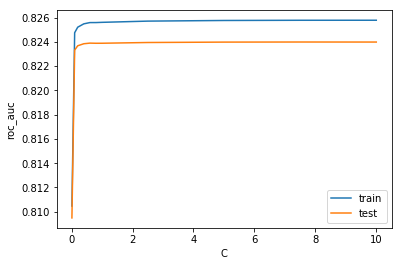

In [11]:
c=[0.01,0.1,0.2,0.4,0.6,0.8,1,2.5,5,7.5,10]
roc_test=res_df.loc[res_df['score']=='test_roc_auc','average']
roc_train=res_df.loc[res_df['score']=='train_roc_auc','average']
plt.plot(c,roc_train,label='train')
plt.plot(c,roc_test,label='test')
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

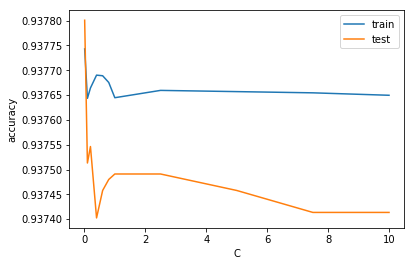

In [9]:
c=[0.01,0.1,0.2,0.4,0.6,0.8,1,2.5,5,7.5,10]
roc_test=res_df.loc[res_df['score']=='test_accuracy','average']
roc_train=res_df.loc[res_df['score']=='train_accuracy','average']
plt.plot(c,roc_train,label='train')
plt.plot(c,roc_test,label='test')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.legend()
plt.show()